<a href="https://colab.research.google.com/github/bjuhasz7054/NBD_Deep_learning/blob/main/milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Hyperparameters Config


In [ ]:
RANDOM_SEED = 42
TRAIN_TEST_SPLIT_RATIO = 0.8
EPOCHS = 30
TRAIN_BATCH_SIZE = 256
VALIDATE_BATCH_SIZE = 256
DECREASE_RATIO = 0.2
PATIENCE=5
LEARNING_RATE=0.001

# Load Data

Download dataset and labels


In [ ]:
%%capture
# download dataset
!gdown --id 1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
!unzip fairface-img-margin025-trainval.zip
!rm fairface-img-margin025-trainval.zip

# download labels
!gdown --id 1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
!gdown --id 1wOdja-ezstMEp81tX1a-EYkFebev4h7D

Initialize dataframes

In [ ]:
import pandas as pd 

def split_dataset(base_dataframe, fraction):
  first = base_dataframe.sample(frac=fraction, random_state=RANDOM_SEED)
  second = base_dataframe.drop(first.index)
  return (first, second)

initial_train_dataset, _ =  split_dataset(
  base_dataframe=pd.read_csv(
    "fairface_label_train.csv"
  ),
  fraction=DECREASE_RATIO
)

validate_labels_df, _ = split_dataset(
  base_dataframe=pd.read_csv(
    "fairface_label_val.csv"
  ),
  fraction=DECREASE_RATIO
)

train_labels_df, test_labels_df = split_dataset(
  base_dataframe=initial_train_dataset,
  fraction=TRAIN_TEST_SPLIT_RATIO
)

In [ ]:
TRAIN_SIZE = len(train_labels_df)
VALIDATE_SIZE = len(validate_labels_df)
TEST_SIZE = len(test_labels_df)

dataset_size = TRAIN_SIZE + VALIDATE_SIZE + TEST_SIZE
print(f"train percantage = {TRAIN_SIZE / dataset_size * 100}%")
print(f"test percantage = {TEST_SIZE / dataset_size * 100}%")
print(f"validate percantage = {VALIDATE_SIZE / dataset_size * 100}%")

train percantage = 71.02865916069601%
test percantage = 17.75844421699079%
validate percantage = 11.212896622313204%


In [ ]:
train_labels_df

,file,age,gender,race,service_test
72021,train/72022.jpg,20-29,Female,Middle Eastern,True
30696,train/30697.jpg,40-49,Male,Latino_Hispanic,True
25238,train/25239.jpg,30-39,Male,Latino_Hispanic,True
10700,train/10701.jpg,40-49,Male,Black,False
59692,train/59693.jpg,20-29,Male,Latino_Hispanic,True
...,...,...,...,...,...
18369,train/18370.jpg,20-29,Female,East Asian,False
25172,train/25173.jpg,20-29,Female,White,True
7635,train/7636.jpg,20-29,Male,White,True
23388,train/23389.jpg,30-39,Female,East Asian,True


Encode categorical data to one-hot representation

In [ ]:
class_columns=['age', 'race', 'gender']
def one_hot_encode_data(dataframe,):
  new_df=dataframe.copy()
  for coloumn in class_columns[:-1]:
    new_df[coloumn]=dataframe[coloumn].str.get_dummies().values.tolist()
  new_df['gender']=(dataframe['gender'] == 'Male').astype(int)
  return new_df

oh_train_labels_df=one_hot_encode_data(train_labels_df)
oh_validate_labels_df=one_hot_encode_data(validate_labels_df)
oh_test_labels_df=one_hot_encode_data(test_labels_df)

print(oh_train_labels_df[['age', 'race', 'gender']])

                               age                   race  gender
72021  [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 1, 0, 0]       0
30696  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       1
25238  [0, 0, 0, 0, 1, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       1
10700  [0, 0, 0, 0, 0, 1, 0, 0, 0]  [1, 0, 0, 0, 0, 0, 0]       1
59692  [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0]       1
...                            ...                    ...     ...
18369  [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       0
25172  [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 1]       0
7635   [0, 0, 1, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 1]       1
23388  [0, 0, 0, 0, 1, 0, 0, 0, 0]  [0, 1, 0, 0, 0, 0, 0]       0
85260  [0, 0, 0, 0, 1, 0, 0, 0, 0]  [1, 0, 0, 0, 0, 0, 0]       0

[13879 rows x 3 columns]


Encode categorical data to integer representation

In [ ]:
class_columns=['age', 'race', 'gender']
def int_encode_data(dataframe):
  new_df=dataframe.copy()
  for coloumn in class_columns:
    new_df[coloumn]=pd.factorize(dataframe[coloumn], sort=True)[0]
  return new_df

int_train_labels_df=int_encode_data(train_labels_df)
int_validate_labels_df=int_encode_data(validate_labels_df)
int_test_labels_df=int_encode_data(test_labels_df)

print(int_train_labels_df[['age', 'race', 'gender']])  


       age  race  gender
72021    2     4       0
30696    5     3       1
25238    4     3       1
10700    5     0       1
59692    2     3       1
...    ...   ...     ...
18369    2     1       0
25172    2     6       0
7635     2     6       1
23388    4     1       0
85260    4     0       0

[13879 rows x 3 columns]


Preprocess Image with JPEG compression

In [ ]:
import numpy as np
import imgaug.augmenters as iaa
from PIL import Image


def jpeg_compress(np_image):
  # This function can only work with this datatype
  img_list = [np_image.astype("uint8")]
  
  # 60 - 75 means, a quality of 40 - 25
  seq_free = iaa.Sequential(
    [iaa.JpegCompression(compression=(60, 75))]
  )
   
  return seq_free(images=img_list)[0].astype("float32")

Create Data Generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import random 
import numpy as np


train_datagen = ImageDataGenerator(
  rotation_range=random.randint(40,90),
  width_shift_range=0.2,
  height_shift_range=0.2,
  rescale=1./255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest',
  preprocessing_function = jpeg_compress
)

validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

common_generator_settings = {
  "x_col": "file",
  "y_col": ['age', 'race', 'gender'],
  "class_mode": "multi_output",
  "seed": RANDOM_SEED,
  "target_size": (224, 224),
  "validate_filenames": True
}

train_generator = train_datagen.flow_from_dataframe(
  dataframe=oh_train_labels_df,
  batch_size=TRAIN_BATCH_SIZE,
  **common_generator_settings
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe=oh_test_labels_df,
  batch_size=128,
  **common_generator_settings,
  shuffle=False
)

validate_generator = validate_datagen.flow_from_dataframe(
  dataframe=oh_validate_labels_df,
  batch_size=VALIDATE_BATCH_SIZE,
  **common_generator_settings
)

Found 13879 validated image filenames.
Found 3470 validated image filenames.
Found 2191 validated image filenames.


# Create Model

In [ ]:
%%capture
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

# fix spaghetti research package
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from keras_vggface.vggface import VGGFace

Transfer learning using VGG-19 Network pretrained on faces

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

for layer in vgg_features.layers:
    layer.trainable = False

x = vgg_features.output
x = Dense(4048, activation='relu')(x)
x = Dense(4048, activation='relu')(x)

# 3 outputs, one for each category
age_output=Dense(9, activation='softmax', name='age')(x)
race_output=Dense(7, activation='softmax', name='race')(x)
gender_output=Dense(1, activation='sigmoid', name='gender')(x)


# this is the model we will train
model = Model(inputs=vgg_features.input, outputs=[age_output, race_output, gender_output])

58925056/58909280 [==============================] - 1s 0us/step


#Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping=EarlyStopping(patience=PATIENCE, verbose=1)
checkpointer=ModelCheckpoint(filepath='/content/drive/MyDrive/figures/model.hdf5', save_best_only=True, verbose=1)

Setup class weights (by category) since dataset is imbalanced

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from keras.utils import np_utils
import keras.backend as K
from itertools import product

def weight_classes(dataframe_column):
  return class_weight.compute_class_weight(
    'balanced',
    classes=pd.unique(dataframe_column),
    y=dataframe_column
  )

age_class_weights_np = weight_classes(train_labels_df.age)
race_class_weights_np = weight_classes(train_labels_df.race)
gender_class_weights_np = weight_classes(train_labels_df.gender)

Custom loss function

In [ ]:
import tensorflow as tf
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = tf.dtypes.cast(y_true, tf.float64) * tf.dtypes.cast(K.log(y_pred), tf.float64) * tf.dtypes.cast(weights, tf.float64)
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
# Gender is not weighted because the relevant dataset is very close to balanced
loss_age = weighted_categorical_crossentropy(age_class_weights_np)
loss_race = weighted_categorical_crossentropy(race_class_weights_np)

Compile the model

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

model.compile(
  optimizer=Adam(learning_rate=LEARNING_RATE),
  metrics=[Accuracy, BinaryAccuracy, CategoricalAccuracy],
  loss={
      'age': loss_age,
      'race': loss_race,
      'gender': BinaryCrossentropy()  
  }
)

In [ ]:
# load existing model if necessary
from tensorflow import keras
model=keras.models.load_model('/content/drive/MyDrive/figures/model.hdf5')

In [ ]:
model.fit(
  train_generator,
  steps_per_epoch=TRAIN_SIZE/TRAIN_BATCH_SIZE,
  validation_data=validate_generator,
  validation_steps=VALIDATE_SIZE/VALIDATE_BATCH_SIZE,
  epochs=EPOCHS,
  callbacks=(early_stopping, checkpointer)
)

Epoch 1/30
55/54 [==============================] - ETA: -3s - loss: 4.9705 - age_loss: 2.5164 - race_loss: 1.8331 - gender_loss: 0.6211 - age_accuracy: 0.1860 - race_accuracy: 0.2783 - gender_accuracy: 0.6330
Epoch 00001: val_loss improved from inf to 3.95154, saving model to /content/drive/MyDrive/figures/model.hdf5
54/54 [==============================] - 405s 6s/step - loss: 4.9705 - age_loss: 2.5164 - race_loss: 1.8331 - gender_loss: 0.6211 - age_accuracy: 0.1860 - race_accuracy: 0.2783 - gender_accuracy: 0.6330 - val_loss: 3.9515 - val_age_loss: 2.0585 - val_race_loss: 1.4696 - val_gender_loss: 0.4234 - val_age_accuracy: 0.3254 - val_race_accuracy: 0.4359 - val_gender_accuracy: 0.7919
Epoch 2/30
55/54 [==============================] - ETA: -3s - loss: 4.4645 - age_loss: 2.2691 - race_loss: 1.6494 - gender_loss: 0.5460 - age_accuracy: 0.2507 - race_accuracy: 0.3621 - gender_accuracy: 0.7074
Epoch 00002: val_loss improved from 3.95154 to 3.55986, saving model to /content/drive/MyD

KeyboardInterrupt: ignored

# Evaluate Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
# load best model
test_model = load_model("/content/drive/MyDrive/figures/model.hdf5", custom_objects={'loss': weighted_categorical_crossentropy})
Age_pred, Race_pred, Gender_pred = test_model.predict(test_generator)

In [ ]:
# convert output vectors to single integers
age_pred = np.argmax(Age_pred, axis=1)
race_pred = np.argmax(Race_pred, axis=1)
gender_pred=Gender_pred>=0.5

Confusion matrices

In [ ]:
age_labels=['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
race_labels=['Black', 'East Asian', 'Indian', 'Latino Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
gender_labels=['Female', 'Male']

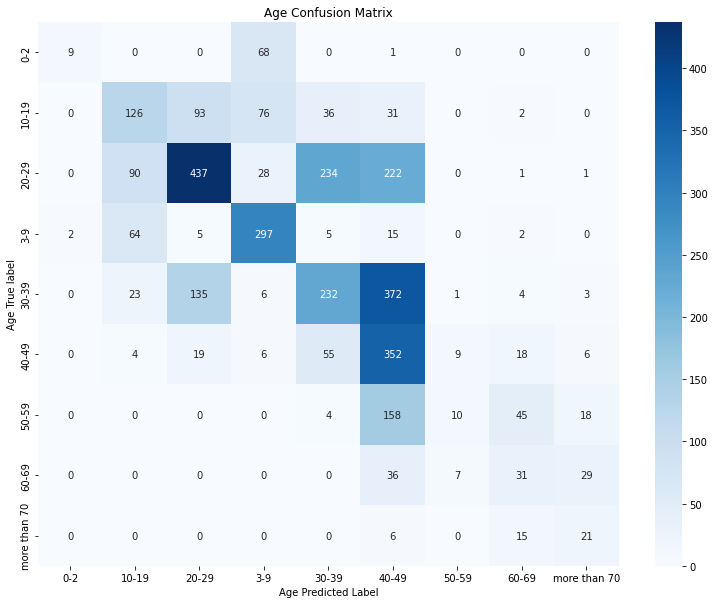

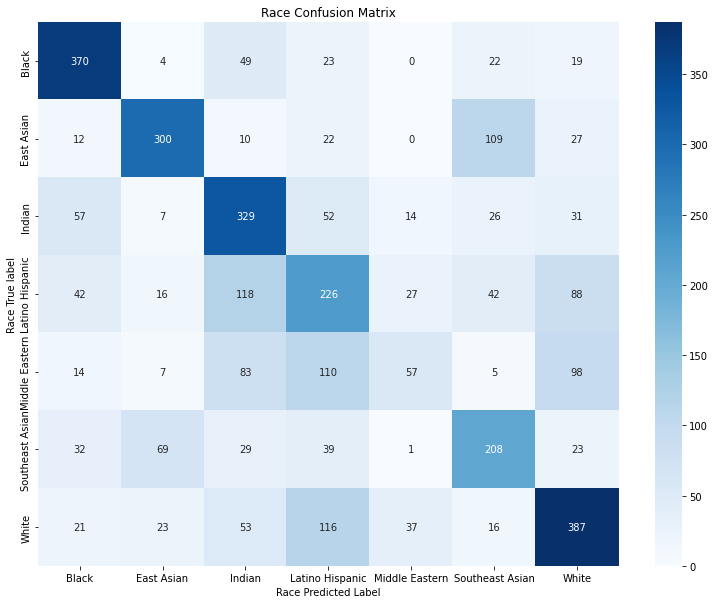

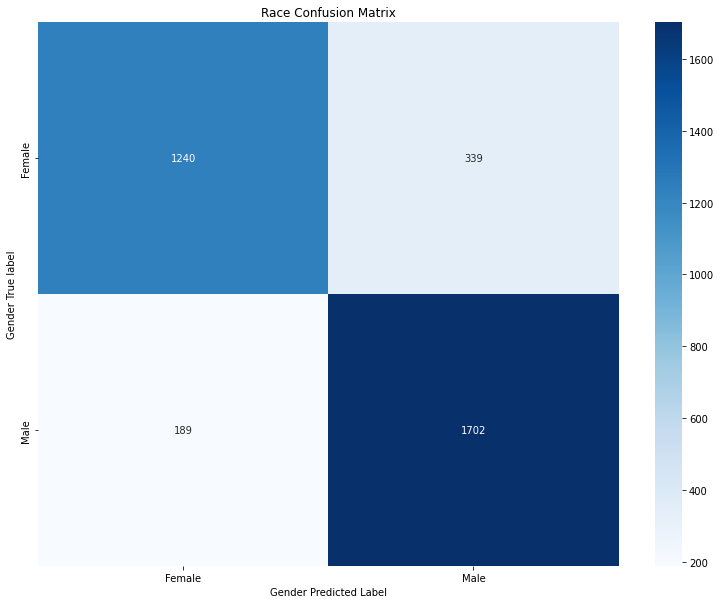

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf = confusion_matrix(int_test_labels_df['age'].values, age_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Age Predicted Label',
       ylabel='Age True label');
ax.set_title('Age Confusion Matrix') 
ax.xaxis.set_ticklabels(age_labels)
ax.yaxis.set_ticklabels(age_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['race'].values, race_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Race Predicted Label',
       ylabel='Race True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(race_labels)
ax.yaxis.set_ticklabels(race_labels)
plt.show()

conf = confusion_matrix(int_test_labels_df['gender'].values, gender_pred)
plt.figure(figsize=(13,10))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
ax.set(xlabel='Gender Predicted Label',
       ylabel='Gender True label');
ax.set_title('Race Confusion Matrix') 
ax.xaxis.set_ticklabels(gender_labels)
ax.yaxis.set_ticklabels(gender_labels)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('Age Classification Report\n')
print(classification_report(int_test_labels_df['age'], age_pred, target_names = age_labels))

print('Race Classification Report\n')
print(classification_report(int_test_labels_df['race'], race_pred, target_names = race_labels))

print('Gender Classification Report\n')
print(classification_report(int_test_labels_df['gender'], gender_pred, target_names = gender_labels))

Age Classification Report

              precision    recall  f1-score   support

         0-2       0.82      0.12      0.20        78
       10-19       0.41      0.35      0.38       364
       20-29       0.63      0.43      0.51      1013
         3-9       0.62      0.76      0.68       390
       30-39       0.41      0.30      0.35       776
       40-49       0.30      0.75      0.42       469
       50-59       0.37      0.04      0.08       235
       60-69       0.26      0.30      0.28       103
more than 70       0.27      0.50      0.35        42

    accuracy                           0.44      3470
   macro avg       0.45      0.39      0.36      3470
weighted avg       0.48      0.44      0.42      3470

Race Classification Report

                 precision    recall  f1-score   support

          Black       0.68      0.76      0.71       487
     East Asian       0.70      0.62      0.66       480
         Indian       0.49      0.64      0.55       516
Latino Hisp

# AE model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import random 
import numpy as np


train_datagen = ImageDataGenerator(
  #rotation_range=random.randint(40,90),
  #width_shift_range=0.2,
  #height_shift_range=0.2,
  rescale=1./255,
  #shear_range=0.2,
  #zoom_range=0.2,
  #horizontal_flip=True,
  #fill_mode='nearest',
  preprocessing_function = jpeg_compress
)

validate_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

common_generator_settings = {
  "x_col": "file",
  "class_mode": 'input',
  "seed": RANDOM_SEED,
  "target_size": (224, 224),
  "validate_filenames": True
}

train_generator = train_datagen.flow_from_dataframe(
  dataframe=encoded_train_labels_df,
  batch_size=8,
  **common_generator_settings
)

test_generator = test_datagen.flow_from_dataframe(
  dataframe=encoded_test_labels_df,
  **common_generator_settings
)

validate_generator = validate_datagen.flow_from_dataframe(
  dataframe=encoded_validate_labels_df,
  batch_size=VALIDATE_BATCH_SIZE,
  **common_generator_settings
)

Found 13879 validated image filenames.
Found 3470 validated image filenames.
Found 2191 validated image filenames.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Load the previously trained classification model without the Dense layers, then add a decoder network to it so it can function as an AutoEncoder.

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/figures/model.hdf5', custom_objects={'loss': weighted_categorical_crossentropy})

input=model.input

for layer in model.layers[:-5]:
  layer.trainable=False

x=model.layers[-6].output

code=x

encoder=keras.Model(input, code)

x=keras.layers.Reshape((1, 1, 512))(code)

x=keras.layers.UpSampling2D((7,7))(x)

for filter in [512]:
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.UpSampling2D((2,2))(x)

for filter in [512, 256]:
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.UpSampling2D((2,2))(x)
for filter in [128, 64]:
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.Conv2D(filter, kernel_size=3, padding='same', activation='relu')(x)
  x=keras.layers.UpSampling2D((2,2))(x)
output=keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)


ae=keras.Model(input, output)

decoder_input=keras.Input(shape=(512))
x=decoder_input
for layer in ae.layers[len(encoder.layers):]:
  x=layer(x)
decoder_output=x

decoder=keras.Model(decoder_input, decoder_output)

In [ ]:
ae.summary()
encoder.summary()
decoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime

checkpointer=ModelCheckpoint(filepath='/content/drive/MyDrive/figures/ae_model.hdf5', save_best_only=True, monitor='loss', verbose=1)

ae.compile(optimizer='adam', loss='mse')


In [ ]:
ae.fit(
  train_generator,
  steps_per_epoch=TRAIN_SIZE//8,
  epochs=10,
  callbacks=(checkpointer)
)

Epoch 1/10
1734/1734 [==============================] - ETA: 0s - loss: 0.0266
Epoch 00001: loss improved from inf to 0.02655, saving model to /content/drive/MyDrive/figures/ae_model.hdf5
1734/1734 [==============================] - 552s 309ms/step - loss: 0.0266
Epoch 2/10
1734/1734 [==============================] - ETA: 0s - loss: 0.0259
Epoch 00002: loss improved from 0.02655 to 0.02590, saving model to /content/drive/MyDrive/figures/ae_model.hdf5
1734/1734 [==============================] - 533s 308ms/step - loss: 0.0259
Epoch 3/10
1734/1734 [==============================] - ETA: 0s - loss: 0.0253
Epoch 00003: loss improved from 0.02590 to 0.02535, saving model to /content/drive/MyDrive/figures/ae_model.hdf5
1734/1734 [==============================] - 535s 309ms/step - loss: 0.0253
Epoch 4/10
1734/1734 [==============================] - ETA: 0s - loss: 0.0249
Epoch 00004: loss improved from 0.02535 to 0.02490, saving model to /content/drive/MyDrive/figures/ae_model.hdf5
1734/173

KeyboardInterrupt: ignored

Load 10 pictures from the dataset

In [ ]:
import glob
import tqdm
import matplotlib
x_train=np.empty((10, 224, 224, 3), dtype=np.uint8)
imgs=glob.glob("train/*.jpg")
img_count=0
for img in tqdm.tqdm(imgs):
   x_train[img_count]=matplotlib.image.imread(img)

   img_count+=1
   
   if(img_count==10):
     break

  0%|          | 9/86744 [00:00<02:31, 574.23it/s]


Load previously saved AutoEncoder model if necessary

In [ ]:
ae=keras.models.load_model(filepath='/content/drive/MyDrive/figures/ae_model.hdf5')
encoder=keras.Model(ae.input, ae.layers[19].output)

decoder_input=keras.Input(shape=(512))
x=decoder_input
for layer in ae.layers[len(encoder.layers):]:
  x=layer(x)
decoder_output=x

decoder=keras.Model(decoder_input, decoder_output)

Linear interpolation between two pictures using the latent space

In [ ]:
from matplotlib import animation
import tqdm
def lin_pol(x1, x2, encoder, decoder, name='proba.mp4'):
  '''Generates animation that shows the linear interpolation between samples

  Params:
    x1, x2:
      Input samples, linear interpolation will be done from x1 to x2
    encoder:
      Encoder model of the AutoEncoder network
    decoder:
      Decoder model of the AutoEncoder network
    name:
      Name of the animation file that will be saved.
  
  Usage:
    Example usage of the function:

    >>>lin_pol(x_train[0:1], x_train[8:9], encoder, decoder, name='ae_lin_pol_0_9.mp4')
    100%|██████████| 501/501 [09:51<00:00,  1.18s/it]

  '''
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(111)
  code1=encoder(x1/255)
  code2=encoder(x2/255)
  code=np.zeros((1, 512))
  ims=[]
  for i in tqdm.tqdm(range(500+1)):
    for j in range(512):
      code[0][j]=code1[0][j]+(code2[0][j]-code1[0][j])/500*i
    ttl = plt.text(0.5, 1.01, str(i/5)+"% sample", horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    im=plt.imshow(decoder(code)[0])
    ims.append([im, ttl])
  ani=animation.ArtistAnimation(fig, ims, blit=True, interval=50)
  ani.save("/content/drive/MyDrive/figures/"+name)

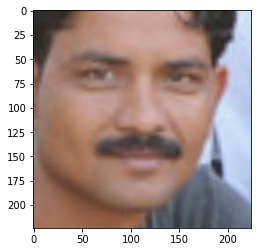

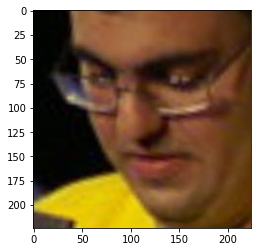

In [ ]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(x_train[9])

100%|██████████| 501/501 [09:51<00:00,  1.18s/it]


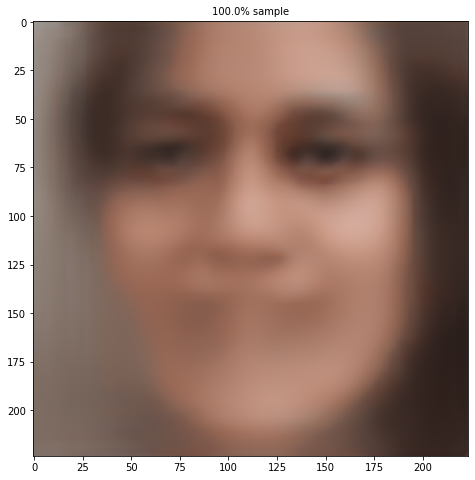

In [ ]:
lin_pol(x_train[0:1], x_train[8:9], encoder, decoder, name='ae_lin_pol_0_9.mp4')